### Bhavesh Hiranand Chainani
#### Silent Eight Data Science Assessment

In [296]:
## Import all relevant python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE 

In [297]:
## Read in data
data = pd.read_csv('data/all_trxns.csv')

### Exploratory Data Analysis (EDA)

In [298]:
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35


In [299]:
data.shape
# 5302 rows, 9 columns

(5302, 9)

In [300]:
data.dtypes

customer                object
customer_country        object
fraud_flag              object
timestamp               object
counterparty             int64
counterparty_country    object
type                    object
ccy                     object
amount                  object
dtype: object

In [301]:
data.describe()

,counterparty
count,5.302000e+03
mean,5.626952e+13
std,2.609480e+13
min,1.136138e+13
25%,3.259593e+13
50%,5.715527e+13
75%,7.748636e+13
max,9.972984e+13


In [302]:
## We notice that the timestamp column is a string, hence it is important to convert it to datetime format
type(data['timestamp'][0])

str

In [303]:
## convert timestamp column from string to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [304]:
## Identify any null values
data.isna().sum()

customer                  0
customer_country          0
fraud_flag                0
timestamp                 0
counterparty              0
counterparty_country    499
type                      0
ccy                       0
amount                    0
dtype: int64

In [305]:
# We can see the counterparty_country is the only column with null values. 
# We will leave it for now as we do not want to remove any uneccessary rows, 
# given that the dataset is relatively small.

In [306]:
# remove unneccessary strings from amount column (e.g 1,712 to 1712) 
data['amount'] = data['amount'].str.replace('[,$£]','')
# convert amount column to float
data['amount'] = data['amount'].astype(float)

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_83751/656557539.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['amount'] = data['amount'].str.replace('[,$£]','')


In [307]:
data.amount.describe()

count    5.302000e+03
mean     5.043384e+05
std      1.546262e+06
min      9.911000e+01
25%      2.707183e+04
50%      5.163731e+04
75%      1.004043e+05
max      1.277252e+07
Name: amount, dtype: float64

## Relevant Visualisations

In [308]:
## We notice that customers are repeated, hence for visualisation purposes, 
# we will focus on distinct customers

data_cust = data.drop_duplicates(subset=['customer', 'customer_country']).reset_index(drop=True)

In [309]:
data_cust.shape
## there are 100 distinct customers

(100, 9)

<AxesSubplot: >

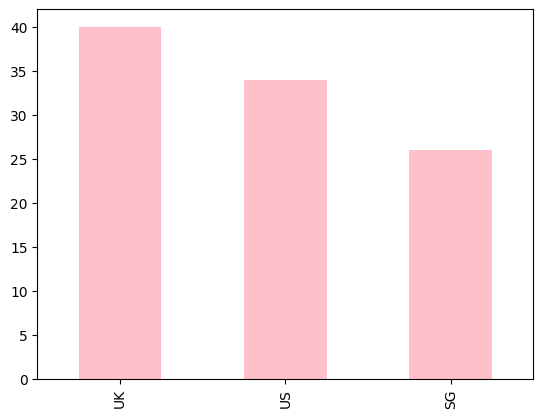

In [310]:
#plot customer country for the 100 customers (data_vis df)
data_cust.customer_country.value_counts().plot(kind='bar', color='pink')

In [311]:
## Counterparty Country

data.counterparty_country.value_counts().to_frame()

## We can see that United States, US and USA are included. 
## Hence, there is a need to change United States, US to USA

,counterparty_country
CN,619
UK,614
JP,537
US,494
DE,484
FR,455
HK,453
BR,392
SG,375
IN,340


In [312]:
data['counterparty_country'] = data['counterparty_country'].replace(['United States', 'US'], 'USA')

<AxesSubplot: title={'center': 'Total Number of Customers per Country'}>

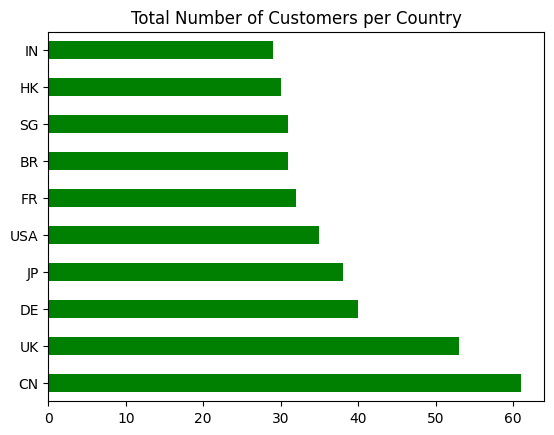

In [313]:
#plot counterparty country based on unique counterparties
data.drop_duplicates(subset=['counterparty','counterparty_country']).reset_index(drop=True).counterparty_country.value_counts().plot(kind='barh', color = 'green', title='Total Number of Customers per Country')

<AxesSubplot: >

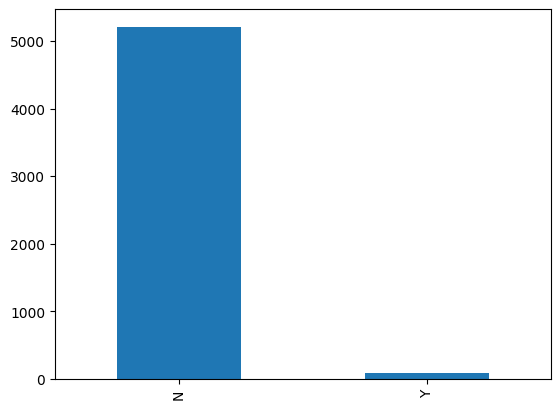

In [314]:
#plot value counts of y label
data.fraud_flag.value_counts().plot(kind='bar')

<AxesSubplot: >

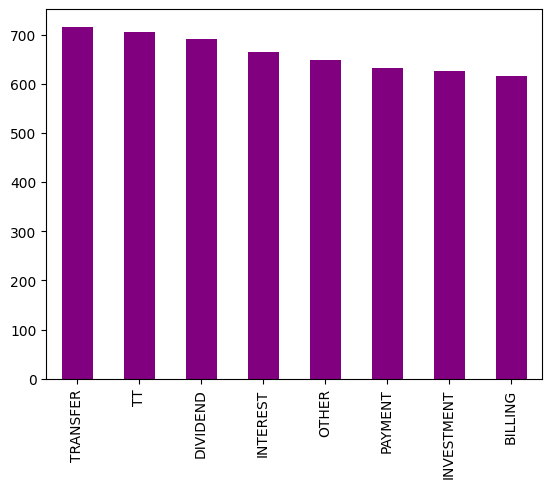

In [315]:
#plot count of different transaction types
data.type.value_counts().plot(kind='bar', color = 'purple')

<AxesSubplot: xlabel='type'>

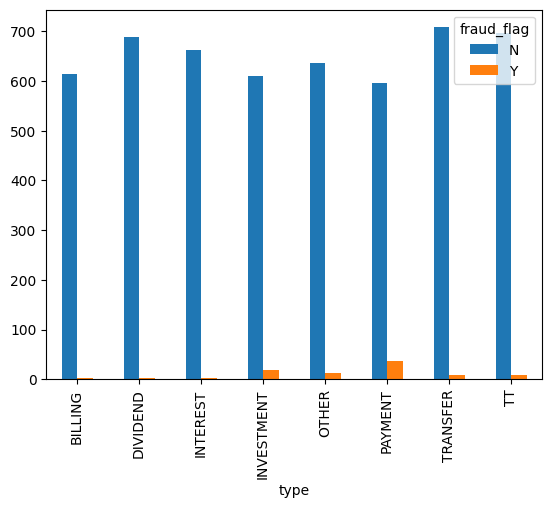

In [316]:
## Visualise distribution of y value for each transaction type
(data
 .groupby(['type', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar()
)

<AxesSubplot: xlabel='ccy'>

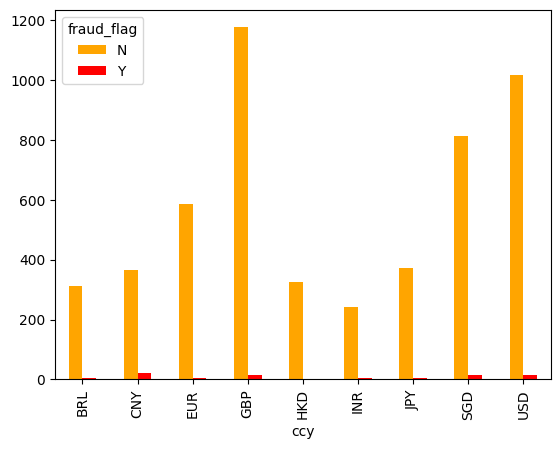

In [317]:
#plot count of types of currency
## Visualise distribution of y value for time of day
(data
 .groupby(['ccy', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar(color=['orange','red'])
)

In [318]:
## Since y value is low, we can do oversampling on minority class to increase model performance

<AxesSubplot: title={'center': 'amount'}, xlabel='fraud_flag'>

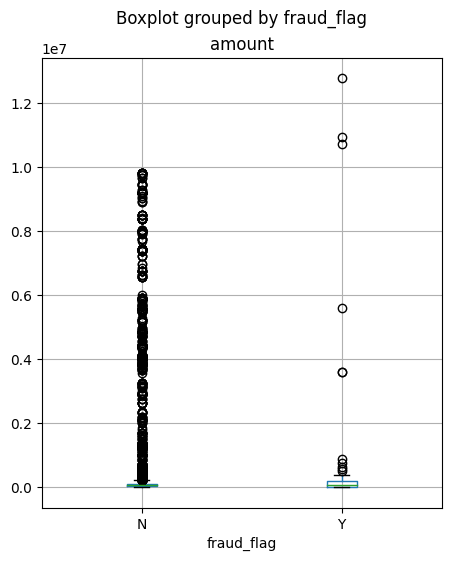

In [319]:
#box plot of relationship between fraud_flag and amount
data.boxplot(column='amount', by='fraud_flag', figsize=(5,6))

In [320]:
## create new column for month year
data['month_year'] = pd.to_datetime(data['timestamp']).dt.to_period('M')
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09


In [321]:
## create new column for time of day
def timeofday(x):
    if (x>=0) & (x<6):
        tod = 'night'
    elif (x>=6) & (x<12):
        tod = 'morning'
    elif (x>=12) & (x<18):
        tod = 'afternoon'
    else:
        tod = 'evening'
    return tod

In [322]:
data['time'] = data.timestamp.dt.hour.map(timeofday) 

In [323]:
data

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year,time
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03,night
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05,night
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05,evening
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07,evening
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09,night
...,...,...,...,...,...,...,...,...,...,...,...
5297,R85394663171656,UK,N,2021-12-20 00:34:56,88635938895767,UK,INTEREST,GBP,25774.25,2021-12,night
5298,R85394663171656,UK,N,2021-12-23 17:49:44,88635938895767,UK,INTEREST,GBP,25660.33,2021-12,afternoon
5299,R85394663171656,UK,N,2021-01-18 15:14:34,88635938895767,UK,OTHER,GBP,32242.92,2021-01,afternoon
5300,R85394663171656,UK,N,2021-04-03 00:13:03,88635938895767,UK,OTHER,GBP,32139.62,2021-04,night


<AxesSubplot: xlabel='month_year'>

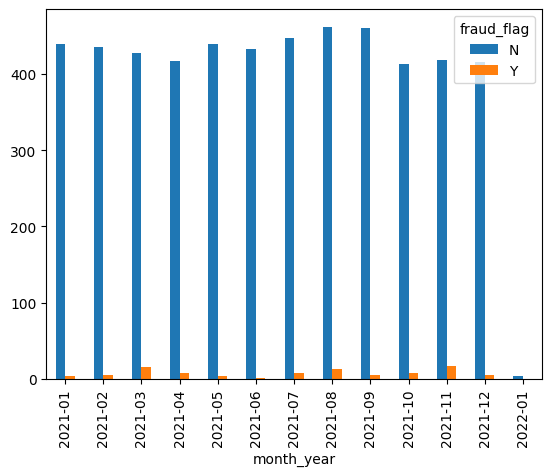

In [324]:
## Visualise distribution of y value for each month
(data
 .groupby(['month_year', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar()
)

<AxesSubplot: xlabel='time'>

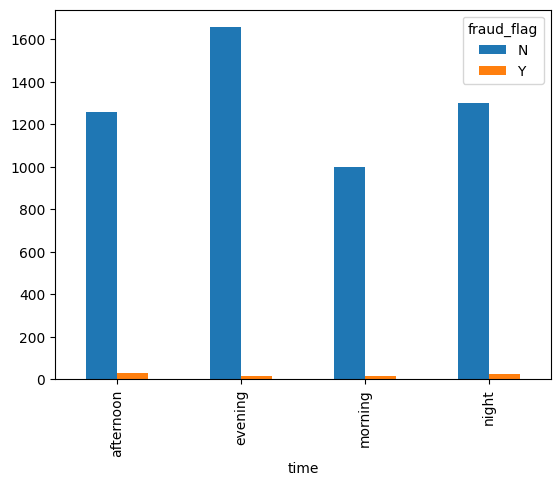

In [325]:
## Visualise distribution of y value for time of day
(data
 .groupby(['time', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar()
)

In [326]:
## REMAP y value to integers (0,1)
data['fraud_flag'] = [0 if x == 'N' else 1 for x in data['fraud_flag']]

In [256]:
## identify if customer has done fraudulent transactions in the past
customer_past_fraud = data.groupby('customer')['fraud_flag'].mean().to_frame().reset_index()

In [257]:
customer_past_fraud.columns = ['customer', 'fraud_past_cust']

In [258]:
## identify if counterparty has done fraudulent transactions in the past
counterparty_past_fraud = data.groupby('counterparty')['fraud_flag'].mean().to_frame().reset_index()

In [259]:
counterparty_past_fraud.columns = ['counterparty', 'fraud_past_counter']

In [260]:
data = pd.merge(data, customer_past_fraud, on="customer")

In [261]:
data = pd.merge(data, counterparty_past_fraud, on = "counterparty")

In [262]:
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year,time,fraud_past_cust,fraud_past_counter
0,C12976926337644,UK,0,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03,night,0.0,0.0
1,C12976926337644,UK,0,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05,night,0.0,0.0
2,C12976926337644,UK,0,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05,evening,0.0,0.0
3,C12976926337644,UK,0,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07,evening,0.0,0.0
4,C12976926337644,UK,0,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09,night,0.0,0.0


### Modelling

In [263]:
## Model 1: use counterparty_country and drop NaN values

In [264]:
## Model 1

## We keep the counterparty_country as one of our features in the model. Hence we remove the NaN values
## and therefore remove the 499 missing values. I have tried another model where I removed the counterparty column
## hence I did not drop the 449 rows. Since the output and feature importance scores are similar, I will stick with this model

In [265]:
data_model = data.dropna().reset_index(drop=True)

In [266]:
data_model.corr()
## since the correlation between fraud_past_counter, fraud_past_cust and amount is not that high
## I will be keeping these columns

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_83751/3863649314.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_model.corr()


,fraud_flag,counterparty,amount,fraud_past_cust,fraud_past_counter
fraud_flag,1.000000,0.009020,0.012756,0.320175,0.800937
counterparty,0.009020,1.000000,-0.035139,-0.035496,0.018549
amount,0.012756,-0.035139,1.000000,-0.056490,0.006591
fraud_past_cust,0.320175,-0.035496,-0.056490,1.000000,0.410716
fraud_past_counter,0.800937,0.018549,0.006591,0.410716,1.000000


In [267]:
## For further data cleaning, we will do remapping of our binary features and creating dummy variables for our categorical features
## We will follow up with oversampling the minority class using SMOTE

In [268]:
# Create dummy variables
dummy_customer_country = pd.get_dummies(data_model['customer_country'], prefix='cust_country', drop_first=True)
dummy_counterparty_country = pd.get_dummies(data_model['counterparty_country'], prefix='count_country', drop_first=True)
dummy_type = pd.get_dummies(data_model['type'], prefix='type', drop_first=True)
dummy_ccy = pd.get_dummies(data_model['ccy'], prefix='ccy', drop_first=True) 

In [269]:
# Drop unnecessary columns
to_drop = ['customer', 'customer_country', 'timestamp', 'counterparty',
           'counterparty_country', 'type', 'ccy','month_year','time']
data_model.drop(to_drop, axis=1, inplace=True)

In [270]:
data_model

,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,48625.25,0.0,0.0
1,0,20637.21,0.0,0.0
2,0,36944.25,0.0,0.0
3,0,48653.70,0.0,0.0
4,0,48765.81,0.0,0.0
...,...,...,...,...
4798,0,25451.05,0.0,0.0
4799,0,25774.25,0.0,0.0
4800,0,25660.33,0.0,0.0
4801,0,32242.92,0.0,0.0


In [271]:
# Merge dataframes into a single dataframe
merged_df = pd.concat([dummy_ccy,dummy_type,dummy_counterparty_country,dummy_customer_country,data_model], axis=1)
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,48625.25,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20637.21,0.0,0.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,36944.25,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,48653.70,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,48765.81,0.0,0.0


In [272]:
## use MinMaxScaler to handle the large values of amount, 
## since machine learning algorithms will give more importance to variables on a larger scale

# Scale only columns that have values greater than 1
to_scale = [col for col in data_model.columns if data_model[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged_df[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged_df[col] = scaled[col]
    
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0.003799,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.001608,0.0,0.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.002885,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.003802,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.003810,0.0,0.0


In [273]:
## create model using SMOTE to oversample minority class

## Naive Approach

X = merged_df.drop('fraud_flag', axis=1)
y = merged_df['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 1.67
% Positive class in Test  = 1.75


##### We will start off with a simple Random Forest model, not accounting for class imbalance

##### Since we are focusing on fraudulent transactions, we want to ensure we identify all True positives accurately, hence we want to minimise our fall negative (FN) count

##### Main metric of evaluation should be Recall =  (TP/TP+FN)

Accuracy = 1.00
Recall = 0.86
Precision = 1.00



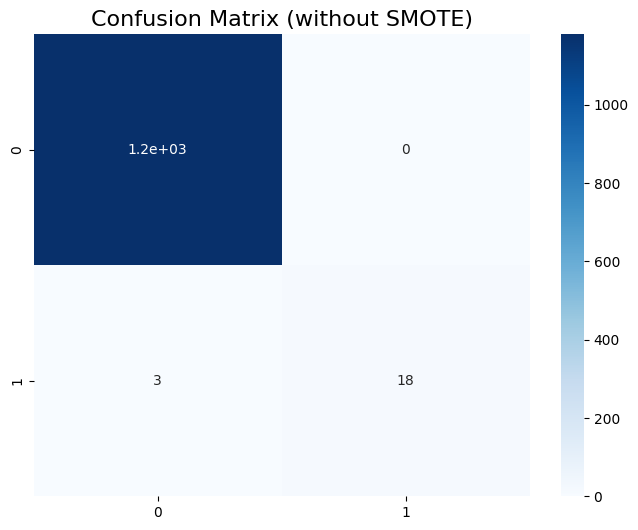

In [274]:
# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

In [275]:
## as we can see for the simple random forest model, the model is being overfitted and is predicting the majority class, which is Y=0
## there is a need to handle class imbalance for our minority class

In [276]:
## handle class imbalance

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (4803, 29)
Shape of X after SMOTE: (9444, 29)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: fraud_flag, dtype: float64

Accuracy = 1.00
Recall = 1.00
Precision = 1.00



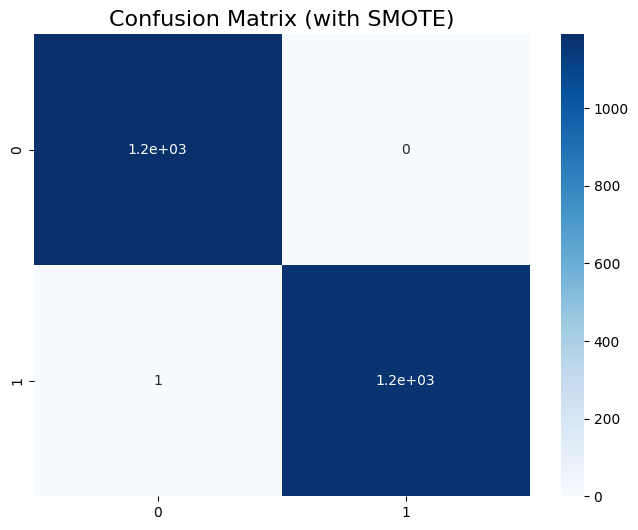

In [277]:
## random forest model with balanced dataset

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

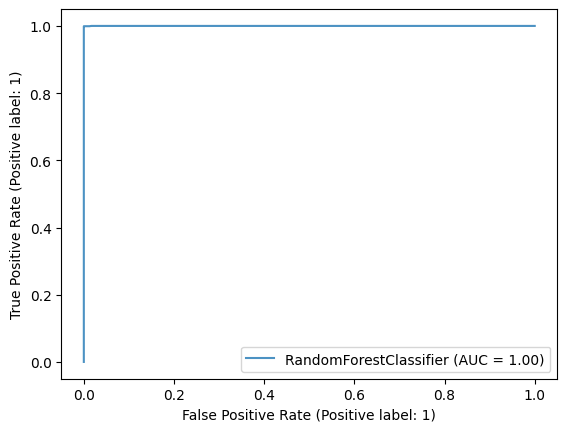

In [278]:
# plot auc-roc curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)

In [279]:
## feature importance scores

importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = X.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) fraud_past_counter             0.497279
 2) fraud_past_cust                0.273406
 3) amount                         0.042473
 4) type_PAYMENT                   0.023073
 5) type_DIVIDEND                  0.021078
 6) count_country_JP               0.020138
 7) type_INTEREST                  0.019364
 8) ccy_CNY                        0.008460
 9) cust_country_UK                0.007611
10) type_TRANSFER                  0.007237
11) ccy_USD                        0.007155
12) count_country_FR               0.006783
13) cust_country_US                0.006121
14) ccy_JPY                        0.005514
15) count_country_CN               0.005200
16) ccy_GBP                        0.005012
17) count_country_HK               0.004780
18) count_country_USA              0.004709
19) type_OTHER                     0.004669
20) count_country_SG               0.004034
21) count_country_IN               0.003859
22) ccy_SGD                        0.003671
23) ccy_HKD                     

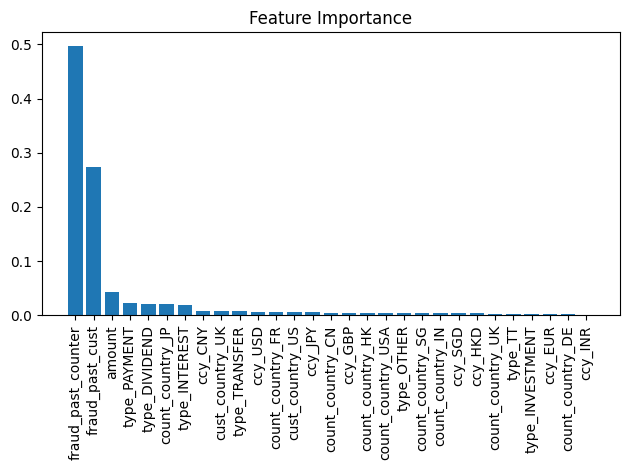

In [280]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

## Model 2
### Add in new features

In [327]:
## identify if customer has done fraudulent transactions in the past
customer_past_fraud = data.groupby('customer')['fraud_flag'].mean().to_frame().reset_index()
customer_past_fraud.columns = ['customer', 'fraud_past_cust']

## identify if counterparty has done fraudulent transactions in the past
counterparty_past_fraud = data.groupby('counterparty')['fraud_flag'].mean().to_frame().reset_index()
counterparty_past_fraud.columns = ['counterparty', 'fraud_past_counter']

data = pd.merge(data, customer_past_fraud, on="customer")
data = pd.merge(data, counterparty_past_fraud, on = "counterparty")

In [328]:
data_model_2 = data.dropna().reset_index(drop=True)

In [329]:
data_model_2

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year,time,fraud_past_cust,fraud_past_counter
0,C12976926337644,UK,0,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03,night,0.0,0.0
1,C12976926337644,UK,0,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05,night,0.0,0.0
2,C12976926337644,UK,0,2021-03-12 01:13:10,77697395249488,CN,TT,GBP,36944.25,2021-03,night,0.0,0.0
3,C12976926337644,UK,0,2021-06-09 18:06:56,77697395249488,CN,TT,CNY,48653.70,2021-06,evening,0.0,0.0
4,C12976926337644,UK,0,2021-08-14 14:03:57,77697395249488,CN,TT,CNY,48765.81,2021-08,afternoon,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,R85394663171656,UK,0,2021-03-24 00:02:45,88635938895767,UK,INTEREST,GBP,25451.05,2021-03,night,0.0,0.0
4799,R85394663171656,UK,0,2021-12-20 00:34:56,88635938895767,UK,INTEREST,GBP,25774.25,2021-12,night,0.0,0.0
4800,R85394663171656,UK,0,2021-12-23 17:49:44,88635938895767,UK,INTEREST,GBP,25660.33,2021-12,afternoon,0.0,0.0
4801,R85394663171656,UK,0,2021-01-18 15:14:34,88635938895767,UK,OTHER,GBP,32242.92,2021-01,afternoon,0.0,0.0


In [284]:
## For further data cleaning, we will do remapping of our binary features and creating dummy variables for our categorical features
## We will follow up with oversampling the minority class using SMOTE

In [285]:
# Create dummy variables
dummy_customer_country_2 = pd.get_dummies(data_model_2['customer_country'], prefix='cust_country', drop_first=True)
dummy_type_2 = pd.get_dummies(data_model_2['type'], prefix='type', drop_first=True)
dummy_ccy_2 = pd.get_dummies(data_model_2['ccy'], prefix='ccy', drop_first=True) 

In [286]:
# Drop unnecessary columns
to_drop = ['customer', 'customer_country', 'timestamp', 'counterparty', 'type', 'ccy','month_year','time']
data_model_2.drop(to_drop, axis=1, inplace=True)

In [287]:
data_model_2

,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,48625.25,0.0,0.0
1,0,20637.21,0.0,0.0
2,0,56691.27,0.0,0.0
3,0,343864.71,0.0,0.0
4,0,57247.35,0.0,0.0
...,...,...,...,...
5297,0,25774.25,0.0,0.0
5298,0,25660.33,0.0,0.0
5299,0,32242.92,0.0,0.0
5300,0,32139.62,0.0,0.0


In [288]:
# Merge dataframes into a single dataframe
merged_df2 = pd.concat([dummy_ccy_2,dummy_type_2,dummy_customer_country_2,data_model_2], axis=1)
merged_df2.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,type_OTHER,type_PAYMENT,type_TRANSFER,type_TT,cust_country_UK,cust_country_US,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,48625.25,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20637.21,0.0,0.0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,56691.27,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,343864.71,0.0,0.0
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,57247.35,0.0,0.0


In [289]:
## use MinMaxScaler to handle the large values of amount, 
## since machine learning algorithms will give more importance to variables on a larger scale

# Scale only columns that have values greater than 1
to_scale = [col for col in data_model_2.columns if data_model_2[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged_df2[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged_df2[col] = scaled[col]
    
merged_df2.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,type_OTHER,type_PAYMENT,type_TRANSFER,type_TT,cust_country_UK,cust_country_US,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0.003799,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0.001608,0.0,0.0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0.004431,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0.026915,0.0,0.0
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0.004474,0.0,0.0


In [290]:
## create model using SMOTE to oversample minority class

## Naive Approach

X = merged_df2.drop('fraud_flag', axis=1)
y = merged_df2['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 1.79
% Positive class in Test  = 1.51


##### We will start off with a simple Random Forest model, not accounting for class imbalance

##### Since we are focusing on fraudulent transactions, we want to ensure we identify all True positives accurately, hence we want to minimise our fall negative (FN) count

##### Main metric of evaluation should be Recall =  (TP/TP+FN)

Accuracy = 1.00
Recall = 0.85
Precision = 1.00



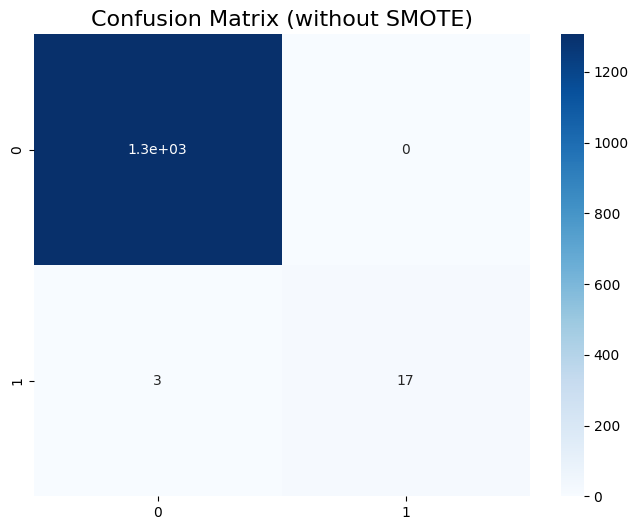

In [291]:
# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

In [292]:
## as we can see for the simple random forest model, the model is being overfitted and is predicting the majority class, which is Y=0
## there is a need to handle class imbalance for our minority class

In [293]:
## handle class imbalance

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (5302, 20)
Shape of X after SMOTE: (10422, 20)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: fraud_flag, dtype: float64

Accuracy = 1.00
Recall = 1.00
Precision = 1.00



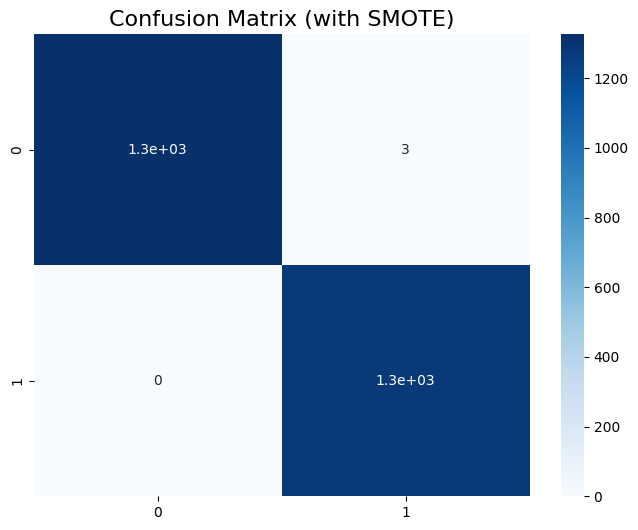

In [294]:
## random forest model with balanced dataset

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

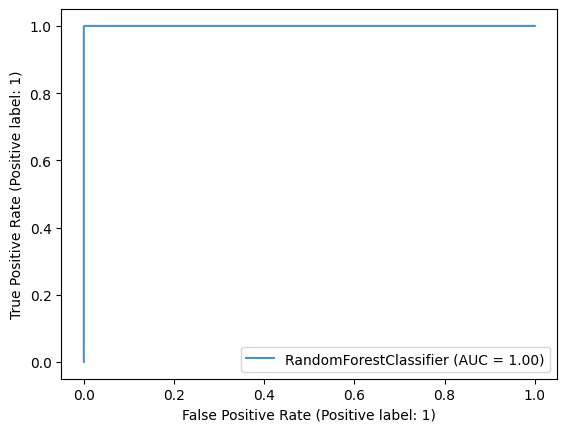

In [295]:
# plot auc-roc curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)

In [69]:
## feature importance scores

importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = X.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) amount                         0.364964
 2) cust_country_UK                0.070837
 3) type_PAYMENT                   0.061500
 4) type_INTEREST                  0.048874
 5) ccy_CNY                        0.046542
 6) type_DIVIDEND                  0.044049
 7) ccy_USD                        0.039602
 8) cust_country_US                0.039190
 9) ccy_SGD                        0.039187
10) ccy_GBP                        0.039059
11) ccy_HKD                        0.034340
12) ccy_EUR                        0.030534
13) type_TRANSFER                  0.030174
14) type_INVESTMENT                0.028597
15) type_OTHER                     0.024460
16) type_TT                        0.022675
17) ccy_INR                        0.018899
18) ccy_JPY                        0.016517


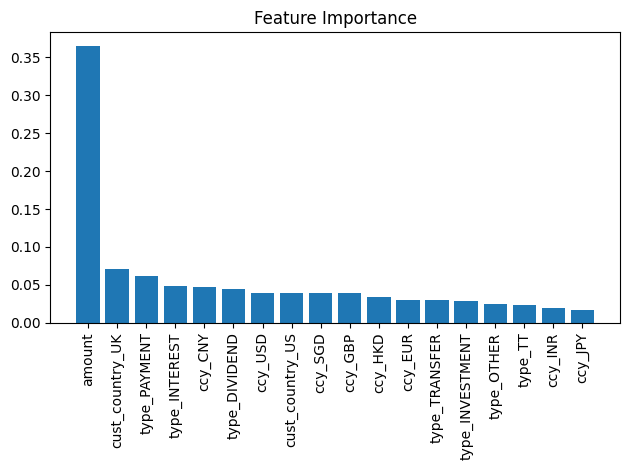

In [70]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Evaluation

In [71]:
## We notice that amount is a key feature with regards to predicting whether a transaction is fraudulent for both models, 
# with a relatively large feature importance score.

In [76]:
## Looking at the SMOTE dataset
smote_data = pd.concat([X_sm,y_sm], axis=1)
smote_data

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,type_INVESTMENT,type_OTHER,type_PAYMENT,type_TRANSFER,type_TT,cust_country_UK,cust_country_US,amount,fraud_flag
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0.003799,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.001608,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0.004431,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.026915,0
4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0.004474,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.018840,1
10418,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.006654,1
10419,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.001049,1
10420,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.006665,1


<AxesSubplot: title={'center': 'amount'}, xlabel='fraud_flag'>

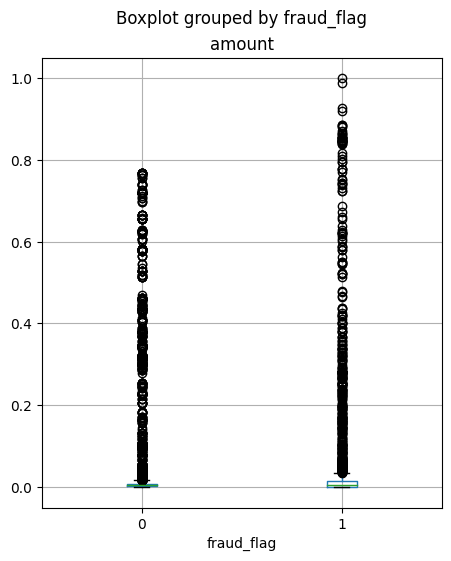

In [77]:
#box plot of relationship between fraud_flag and NORMALISED amount
smote_data.boxplot(column='amount', by='fraud_flag', figsize=(5,6))

In [72]:
## Our main metric of evaluation is recall

In [73]:
## Room for improvement
## Further look into timing interval between payments (ie two payments made within the same day)
## Another aspect would be to create another column for the customer based on their past history.
## For example, if the customer's transaction has been identified as fraudulent in the past, 